In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="------")
project = rf.workspace("my-workspace-k3vyu").project("solar-panel-segmentation-ilpfu")
version = project.version(5)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to solar-panel-segmentation-5 in coco:: 100%|██████████| 796/796 [00:00<00:00, 6018.38it/s]


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.7551 - io_u: 0.0000e+00 - loss: 0.6176 - val_accuracy: 0.6811 - val_io_u: 0.0000e+00 - val_loss: 0.6087
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 415ms/step - accuracy: 0.7845 - io_u: 0.0000e+00 - loss: 0.4945 - val_accuracy: 0.6811 - val_io_u: 0.0000e+00 - val_loss: 0.5791
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 415ms/step - accuracy: 0.7592 - io_u: 0.0000e+00 - loss: 0.4878 - val_accuracy: 0.6811 - val_io_u: 0.0000e+00 - val_loss: 0.5779
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 414ms/step - accuracy: 0.7792 - io_u: 0.0000e+00 - loss: 0.4483 - val_accuracy: 0.6811 - val_io_u: 0.0000e+00 - val_loss: 0.5613
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 389ms/step - accuracy: 0.7663 - io_u: 0.0000e+00 - loss: 0.4476 - val_accuracy: 0.7013 - val_io_u: 0.0000e+00 - val_loss: 0.5656
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 386ms/step - accuracy: 0.7941 - io_u: 0.0000e+00 - loss: 0.4464 - val_accuracy: 0.6834 - val_io_u: 0.0000

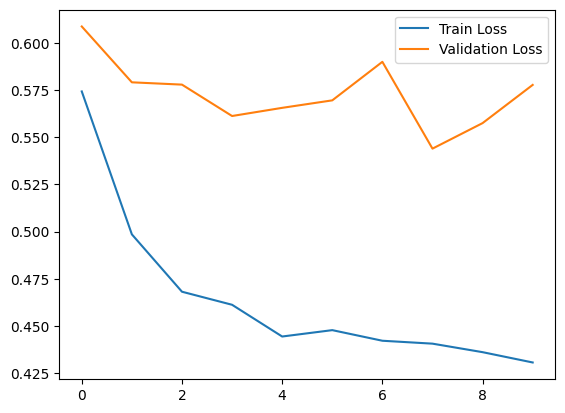

In [7]:
import json
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# 1. JSON Dosya Yükleme
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# 2. Veri Hazırlama (DÜZELTİLMİŞ)
def get_images_and_masks(data, image_folder):
    images = data['images']
    annotations = data['annotations']
    image_files = [image['file_name'] for image in images]

    masks = {}
    images_data = []

    for img_file in image_files:
        img_id = next(item for item in images if item['file_name'] == img_file)['id']

        # Maskeyi 0-1 aralığında oluştur
        height, width = images[0]['height'], images[0]['width']
        mask = np.zeros((height, width), dtype=np.uint8)

        # Segmentation verilerini işle
        for ann in [a for a in annotations if a['image_id'] == img_id]:
            if 'segmentation' in ann and ann['segmentation']:
                poly_points = np.array(ann['segmentation'], dtype=np.int32).reshape(-1, 2)
                cv2.fillPoly(mask, [poly_points], 1)  # 1 kullanıldı

        # Boyutları düzenle (256x256) ve normalize et
        mask = cv2.resize(mask, (256, 256))
        mask = np.expand_dims(mask, axis=-1).astype(np.float32)  # (256,256,1) ve float32

        # Görseli oku ve hazırla
        img = cv2.imread(os.path.join(image_folder, img_file))
        img = cv2.resize(img, (256, 256)) / 255.0  # Normalizasyon

        masks[img_file] = mask
        images_data.append(img)

    return np.array(images_data), np.array(list(masks.values()))

# 3. U-Net Modeli (Güncellenmiş)
def unet_model(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c7)

    return models.Model(inputs=inputs, outputs=outputs)

# 4. Modeli Derleme ve Eğitim
def main():
    # Veri yolları
    train_folder = '/content/solar-panel-segmentation-5/train'
    test_folder = '/content/solar-panel-segmentation-5/test'
    train_json = '/content/solar-panel-segmentation-5/train/_annotations_train.coco_updated.json'
    test_json = '/content/solar-panel-segmentation-5/test/_annotations_test.coco_updated.json'

    # Verileri yükle
    train_data = load_json(train_json)
    test_data = load_json(test_json)
    X_train, y_train = get_images_and_masks(train_data, train_folder)
    X_test, y_test = get_images_and_masks(test_data, test_folder)

    # Modeli oluştur
    model = unet_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])])

    # Eğitim
    history = model.fit(X_train, y_train,
                        batch_size=8,
                        epochs=10,
                        validation_data=(X_test, y_test),
                        shuffle=True)

    # Değerlendirme
    test_loss, test_acc, test_iou = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test IoU: {test_iou:.4f}")

    # Görselleştirme
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

In [12]:
import json
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 1. IoU Metrik Tanımı
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

# 2. Veri Hazırlama
def get_images_and_masks(data, image_folder):
    images = data['images']
    annotations = data['annotations']

    images_data = []
    masks_data = []

    for img_info in images:
        img_file = img_info['file_name']
        img_id = img_info['id']

        # Maskeyi oluştur
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in [a for a in annotations if a['image_id'] == img_id]:
            if 'segmentation' in ann and ann['segmentation']:
                poly = np.array(ann['segmentation'], dtype=np.int32).reshape(-1,2)
                cv2.fillPoly(mask, [poly], 1)

        # Boyutları düzenle
        img = cv2.imread(os.path.join(image_folder, img_file))
        img = cv2.resize(img, (256, 256)) / 255.0
        mask = cv2.resize(mask, (256, 256))
        mask = np.expand_dims(mask, axis=-1).astype(np.float32)

        images_data.append(img)
        masks_data.append(mask)

    return np.array(images_data), np.array(masks_data)

# 3. Düzeltilmiş U-Net Modeli
def unet_model(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    # Block 1
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(x)  # 128x128

    # Block 2
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(p1)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(x)  # 64x64

    # Block 3
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(p2)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(x)  # 32x32

    # Bottleneck
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(p3)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Decoder
    # Block 4
    x = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.concatenate([x, p3])
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Block 5
    x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.concatenate([x, p2])
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Block 6
    x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.concatenate([x, p1])
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return models.Model(inputs=inputs, outputs=outputs)

# 4. Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 5. Model Eğitimi ve Test
def main():
    # Veri yolları
    train_folder = '/content/train'
    test_folder = '/content/test'
    train_json = '/content/train_annotations.json'
    test_json = '/content/test_annotations.json'

    # Veri yükleme
    train_data = load_json(train_json)
    test_data = load_json(test_json)
    X_train, y_train = get_images_and_masks(train_data, train_folder)
    X_test, y_test = get_images_and_masks(test_data, test_folder)

    # Model oluşturma
    model = unet_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', iou_metric]
    )

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=5)
    ]

    # Eğitim
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=8),
        epochs=30,
        validation_data=(X_test, y_test),
        callbacks=callbacks
    )

    # Test
    model.load_weights('best_model.h5')
    results = model.evaluate(X_test, y_test)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test IoU: {results[2]:.4f}")

    # Görselleştirme
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['iou_metric'], label='Train IoU')
    plt.plot(history.history['val_iou_metric'], label='Val IoU')
    plt.legend()
    plt.show()

    # Örnek tahminler
    for i in range(3):
        idx = np.random.randint(len(X_test))
        img = X_test[idx]
        mask = y_test[idx]
        pred = model.predict(img[np.newaxis,...])[0]

        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.title('Original Image')

        plt.subplot(1,3,2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title('True Mask')

        plt.subplot(1,3,3)
        plt.imshow(pred.squeeze() > 0.5, cmap='gray')
        plt.title('Predicted Mask')
        plt.show()

if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: '/content/train_annotations.json'

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5609 - iou_metric: 0.2069 - loss: 0.7801

72/72 ━━━━━━━━━━━━━━━━━━━━ 103s 980ms/step - accuracy: 0.5614 - iou_metric: 0.2077 - loss: 0.7792 - val_accuracy: 0.6541 - val_iou_metric: 0.3926 - val_loss: 0.6348
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6995 - iou_metric: 0.3274 - loss: 0.6207

72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step - accuracy: 0.6996 - iou_metric: 0.3274 - loss: 0.6207 - val_accuracy: 0.7044 - val_iou_metric: 0.4491 - val_loss: 0.5989
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7271 - iou_metric: 0.3401 - loss: 0.5977

72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 0.7272 - iou_metric: 0.3403 - loss: 0.5976 - val_accuracy: 0.7304 - val_iou_metric: 0.3633 - val_loss: 0.5750
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step - accuracy: 0.7577 - iou_metric: 0.3806 - loss: 0.5693 - val_accuracy: 0.6616 - val_iou_metric: 0.4275 - val_loss: 0.6353
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - accuracy: 0.7629 - iou_metric: 0.3658 - loss: 0.5566 - val_accuracy: 0.6848 - val_iou_metric: 0.4464 - val_loss: 0.6332
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 208ms/step - accuracy: 0.7790 - iou_metric: 0.3697 - loss: 0.5374 - val_accuracy: 0.6551 - val_iou_metric: 0.4317 - val_loss: 0.9478
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - accuracy: 0.7905 - iou_metric: 0.3929 - loss: 0.5135 - val_accuracy: 0.6538 - val_iou_metric: 0.4255 - val_loss: 0.7003
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - accuracy: 0.7986 - iou_metric: 0.4124 - loss: 0.4977 - val_accuracy: 0.6495 - val

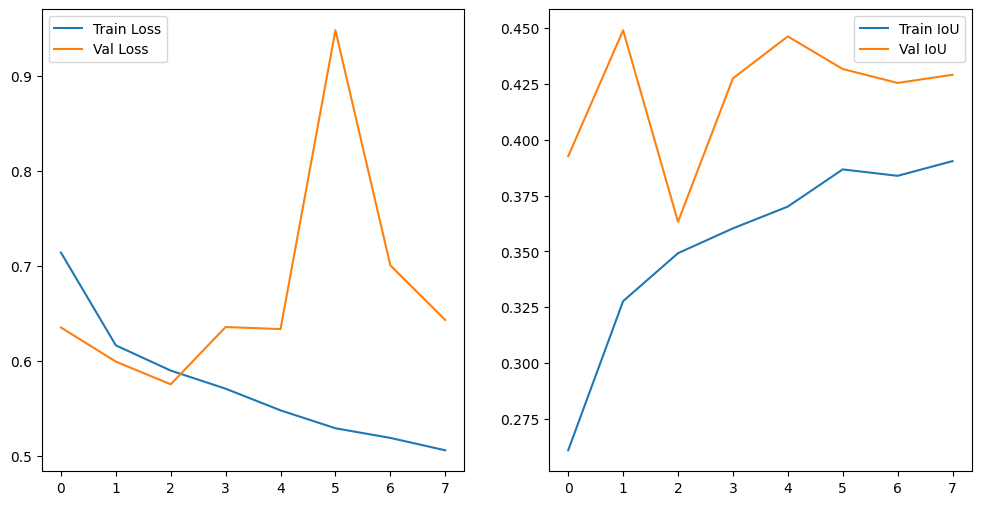

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


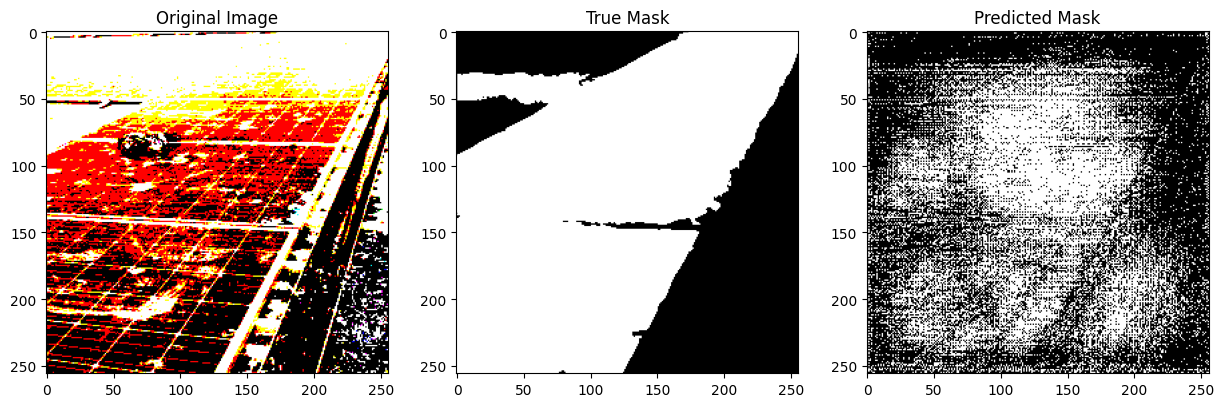

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


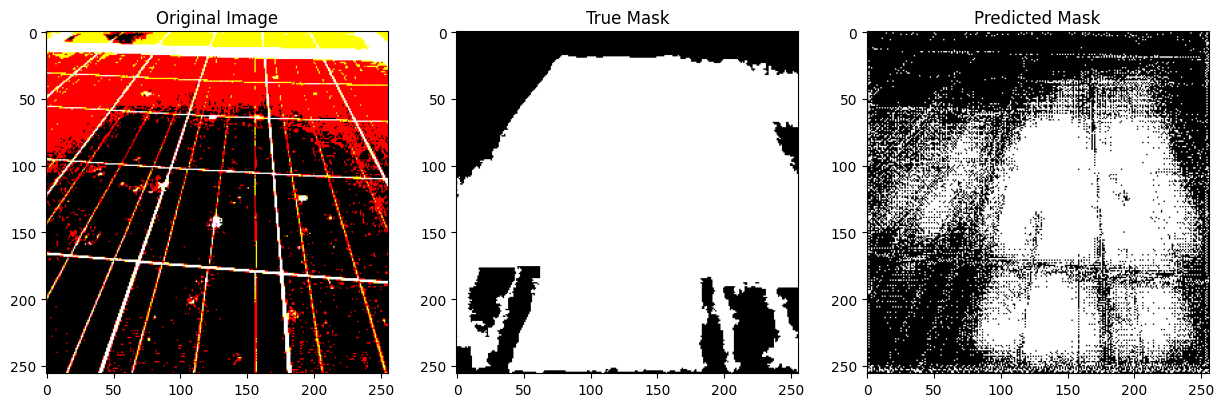

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


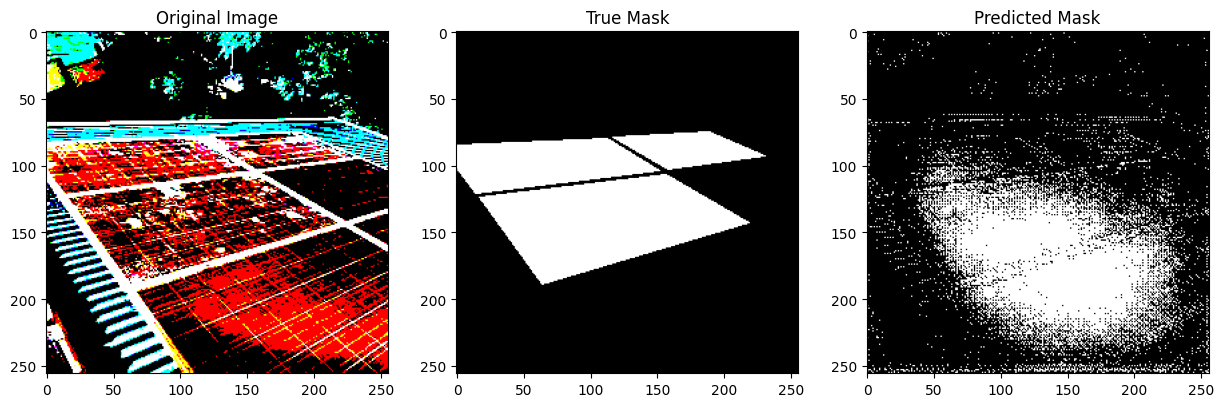

In [18]:
import json
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 1. IoU Metrik Tanımı
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

# 2. Veri Hazırlama
def load_json(json_path):
    with open(json_path) as f:
        return json.load(f)

def get_images_and_masks(data, image_folder):
    images = data['images']
    annotations = data['annotations']

    images_data = []
    masks_data = []

    for img_info in images:
        img_file = img_info['file_name']
        img_id = img_info['id']

        # Maskeyi oluştur
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in [a for a in annotations if a['image_id'] == img_id]:
            if 'segmentation' in ann and ann['segmentation']:
                poly = np.array(ann['segmentation'], dtype=np.int32).reshape(-1,2)
                cv2.fillPoly(mask, [poly], 1)

        # Görüntüyü yükle ve boyutlandır
        img = cv2.imread(os.path.join(image_folder, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))
        mask = np.expand_dims(mask, axis=-1).astype(np.float32)

        images_data.append(img)
        masks_data.append(mask)

    return np.array(images_data), np.array(masks_data)

# 3. Düzeltilmiş ResNet50 U-Net Modeli
def resnet_unet(input_shape=(256, 256, 3)):
    # ResNet50 encoder
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze ResNet weights

    # Skip connection layers
    c1 = base_model.get_layer('conv1_relu').output       # 128x128
    c2 = base_model.get_layer('conv2_block3_out').output # 64x64
    c3 = base_model.get_layer('conv3_block4_out').output # 32x32
    c4 = base_model.get_layer('conv4_block6_out').output # 16x16
    c5 = base_model.get_layer('conv5_block3_out').output # 8x8

    # Decoder
    # Block 1
    x = layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
    x = layers.concatenate([x, c4])
    x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Block 2
    x = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(x)
    x = layers.concatenate([x, c3])
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Block 3
    x = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(x)
    x = layers.concatenate([x, c2])
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Block 4
    x = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(x)
    x = layers.concatenate([x, c1])
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Son upsampling
    x = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return models.Model(inputs=base_model.input, outputs=outputs)

# 4. Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# 5. Model Eğitimi ve Test
def main():
    # Veri yolları
    train_folder = '/content/solar-panel-segmentation-5/train'
    test_folder = '/content/solar-panel-segmentation-5/test'
    train_json = '/content/solar-panel-segmentation-5/train/_annotations_train.coco_updated.json'
    test_json = '/content/solar-panel-segmentation-5/test/_annotations_test.coco_updated.json'

    # Veri yükleme
    train_data = load_json(train_json)
    test_data = load_json(test_json)
    X_train, y_train = get_images_and_masks(train_data, train_folder)
    X_test, y_test = get_images_and_masks(test_data, test_folder)

    # Preprocessing
    X_train = tf.keras.applications.resnet50.preprocess_input(X_train.astype(np.float32))
    X_test = tf.keras.applications.resnet50.preprocess_input(X_test.astype(np.float32))

    # Model oluşturma
    model = resnet_unet()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', iou_metric]
    )

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('resnet_unet_best.h5', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]

    # Eğitim
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=8),
        epochs=30,
        validation_data=(X_test, y_test),
        callbacks=callbacks
    )

    # Test
    model.load_weights('resnet_unet_best.h5')
    results = model.evaluate(X_test, y_test)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test IoU: {results[2]:.4f}")

    # Görselleştirme
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['iou_metric'], label='Train IoU')
    plt.plot(history.history['val_iou_metric'], label='Val IoU')
    plt.legend()
    plt.show()

    # Örnek tahminler
    for i in range(3):
        idx = np.random.randint(len(X_test))
        img = X_test[idx]
        mask = y_test[idx]
        pred = model.predict(img[np.newaxis,...])[0]

        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow((img + 1.0) * 127.5)  # ResNet preprocessing'i geri al
        plt.title('Original Image')

        plt.subplot(1,3,2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title('True Mask')

        plt.subplot(1,3,3)
        plt.imshow(pred.squeeze() > 0.5, cmap='gray')
        plt.title('Predicted Mask')
        plt.show()

if __name__ == "__main__":
    main()